In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from scripts.drawer import russia_plots
import geopandas as gpd
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
# import seaborn as sns
from tqdm.notebook import tqdm
from scripts.drawer import metric_viewer
from copy import deepcopy
import joblib

gauges_file = gpd.read_file('../geo_data/great_db/geometry/russia_gauges.gpkg')
ws_file = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')
ws_file = ws_file.set_index('gauge_id')
basemap_data = gpd.read_file('../geo_data/great_db/geometry/basemap_2023.gpkg')
ugms_shp = gpd.read_file(
    '../geo_data/great_db/geometry/ugms.shp')[['name1', 'geometry']]

In [14]:
era5_file, nse_median = metric_viewer(metric_csv='/workspaces/my_dissertation/conceptual_runs/res_rfr.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)

In [74]:
def read_gauge(gauge_id: str,
               simple: bool = False):

    test_df = xr.open_dataset(
        f'../geo_data/great_db/nc_all_q/{gauge_id}.nc').to_dataframe(
    )[['q_mm_day', 'prcp_e5l', 't_min_e5l', 't_max_e5l', 'Ep']]

    if simple:
        test_df.index.name = 'Date'

        train = test_df[:'2018']
        test = test_df['2018':]
    else:
        test_df['Temp'] = test_df[['t_max_e5l', 't_min_e5l']].mean(axis=1)
        test_df = test_df.rename(columns={'prcp_e5l': 'Prec',
                                          'Ep': 'Evap',
                                          'q_mm_day': 'Q_mm'})
        test_df.index.name = 'Date'
        test_df = test_df.drop(['t_min_e5l', 't_max_e5l'], axis=1)

        train = test_df[:'2018']
        test = test_df['2018':]

    return train, test


def day_agg(df: pd.DataFrame,
            day_aggregations: list = [2**n for n in range(9)]):
    for days in day_aggregations:
        df[[f'prcp_{days}']] = df[['prcp_e5l']].rolling(
            window=days).sum()
        df[[f't_min_{days}']] = df[['t_min_e5l']].rolling(
            window=days).mean()
        df[[f't_max_{days}']] = df[['t_min_e5l']].rolling(
            window=days).mean()
    df = df.dropna()

    return df


def feature_target(data: pd.DataFrame,
                   day_aggregations: list = [2**n for n in range(9)]):
    """_summary_
    Args:
        data (pd.DataFrame): _description_
        day_aggregations (list, optional): _description_.
        Defaults to [2**n for n in range(9)].
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: _description_
    """

    data = day_agg(df=data)

    # get meteo columns
    feature_cols = [item for sublist in
                    [[f'{var}_{day}' for day in day_aggregations]
                     for var in ['prcp', 't_min', 't_max']]
                    for item in sublist]
    features = data[feature_cols]
    # normalize features
    features = (features - features.mean())/features.std()

    target = data[['q_mm_day']]
    target = target.to_numpy().ravel()
    features = features.to_numpy()

    return (features, target)


def nse(predictions, targets):
    return 1-(
        np.nansum((targets-predictions)**2)/np.nansum(
            (targets-np.nanmean(targets))**2))


def rfr_launch(gauge_id: str):
    train, test = read_gauge(gauge_id=gauge_id, simple=True)
    # set data
    x_test, _ = feature_target(deepcopy(test))
    rfr_model = joblib.load(
        f'../conceptual_runs/cal_res/rfr/{gauge_id}.joblib')
    # get prediction
    fin_df = test.iloc[255:, :]
    fin_df['q_mm_rfr'] = rfr_model.predict(x_test)
    res_nse = nse(predictions=fin_df['q_mm_rfr'],
                  targets=fin_df['q_mm_day'])
    
    return res_nse, fin_df


def hbv_launch(gauge_id: str):
    pass


def gr4f_launch(gauge_id: str):
    pass


def tft_launch(gauge_id: str):
    pass


def lstm_launch(gauge_id: str):
    pass


In [48]:
for gauge_id in tqdm(era5_file.index):
    
    res_nse, pred_df = rfr_launch(gauge_id=gauge_id)
    
    pred_df = pred_df[['q_mm_day', 'q_mm_rfr']]
    pred_df.index.name = 'date'
    pred_df = pred_df['2019':]
    
    pred_df.to_csv(f'../conclusions/results/rfr/{gauge_id}.csv')

A Jupyter Widget

In [21]:
for i, geom in enumerate(tqdm(ugms_shp['geometry'])):
    
    ugms_part = era5_file.loc[[geom.intersects(gage_point)
               for gage_point in era5_file['geometry']], :]
    ugms_name = ugms_shp.loc[i, 'name1']
    for g_id in ugms_part.index:
        res_nse, _ = rfr_launch(gauge_id=g_id)
        ugms_part.loc[g_id, 'NSE'] = res_nse
    ugms_nse = ugms_part['NSE'].median()
    
    ugms_shp.loc[i, 'NSE'] = ugms_nse
ugms_shp.loc[ugms_shp['NSE'] < 0, 'NSE'] = 0

A Jupyter Widget

In [ ]:
ugms_shp.to_csv('')

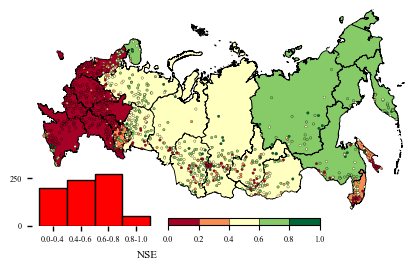

In [22]:
ugms_rfr_fig = russia_plots(gdf_to_plot=era5_file,
                            basemap_data=basemap_data,
                            cmap_name='RdYlGn',
                            metric_col='NSE',
                            distinction_col='',
                            with_histogram=True,
                            ugms=True, ugms_gdf=ugms_shp);
ugms_rfr_fig.savefig('./ugms_fig.tiff',
                   dpi=650)

In [59]:
import glob
import pandas as pd
import sys
sys.path.append('/workspaces/my_dissertation')
from conceptual_runs.scripts.data_readers import read_gauge, get_params
from pathlib import Path
calibration_place = Path('../conceptual_runs/cal_res')
hbv_calibration = Path(f'{calibration_place}/hbv')
gr4j_calibration = Path(f'{calibration_place}/gr4j')

In [65]:
for gauge_id in tqdm(era5_file.index):
    for model in ['hbv', 'gr4j']:
        try:
            if model == 'hbv':
                train, test = read_gauge(gauge_id=gauge_id)
                nse, res_df = get_params(gauge_id=gauge_id,
                                        model_name=model,
                                        params_path=hbv_calibration,
                                        train=train, test=test,
                                        with_plot=False)
                res_df = res_df.loc['2019':, ['Q_mm', 'Q_sim']]
                res_df.index.name = 'date'
                res_df.to_csv(f'../conclusions/results/hbv/{gauge_id}.csv')
            elif model == 'gr4j':
                train, test = read_gauge(gauge_id=gauge_id)
                nse, res_df = get_params(gauge_id=gauge_id,
                                        model_name=model,
                                        params_path=gr4j_calibration,
                                        train=train, test=test,
                                        with_plot=False)
                res_df = res_df.loc['2019':, ['Q_mm', 'Q_sim']]
                res_df.index.name = 'date'
                res_df.to_csv(f'../conclusions/results/gr4j/{gauge_id}.csv')
        except Exception:
            pass

A Jupyter Widget

In [75]:
for gauge_id in tqdm(era5_file.index):
    rfr_nse, res_df = rfr_launch(gauge_id=gauge_id)
    res_df = res_df.loc['2019':, ['q_mm_day', 'q_mm_rfr']]
    res_df.index.name = 'date'
    res_df.to_csv(f'../conclusions/results/rfr/{gauge_id}.csv')

A Jupyter Widget

In [71]:
res_df

q_mm_day  q_mm_rfr
date                          
2019-01-01  0.584459  0.450807
2019-01-02  0.592200  0.441208
2019-01-03  0.599941  0.455452
2019-01-04  0.607682  0.453478
2019-01-05  0.615423  0.479914
...              ...       ...
2020-12-27  0.928941  0.916555
2020-12-28  0.936682  0.898711
2020-12-29  0.940552  0.883306
2020-12-30  0.948294  0.886248
2020-12-31  0.956035  0.916129

[731 rows x 2 columns]

### CDF PLOT

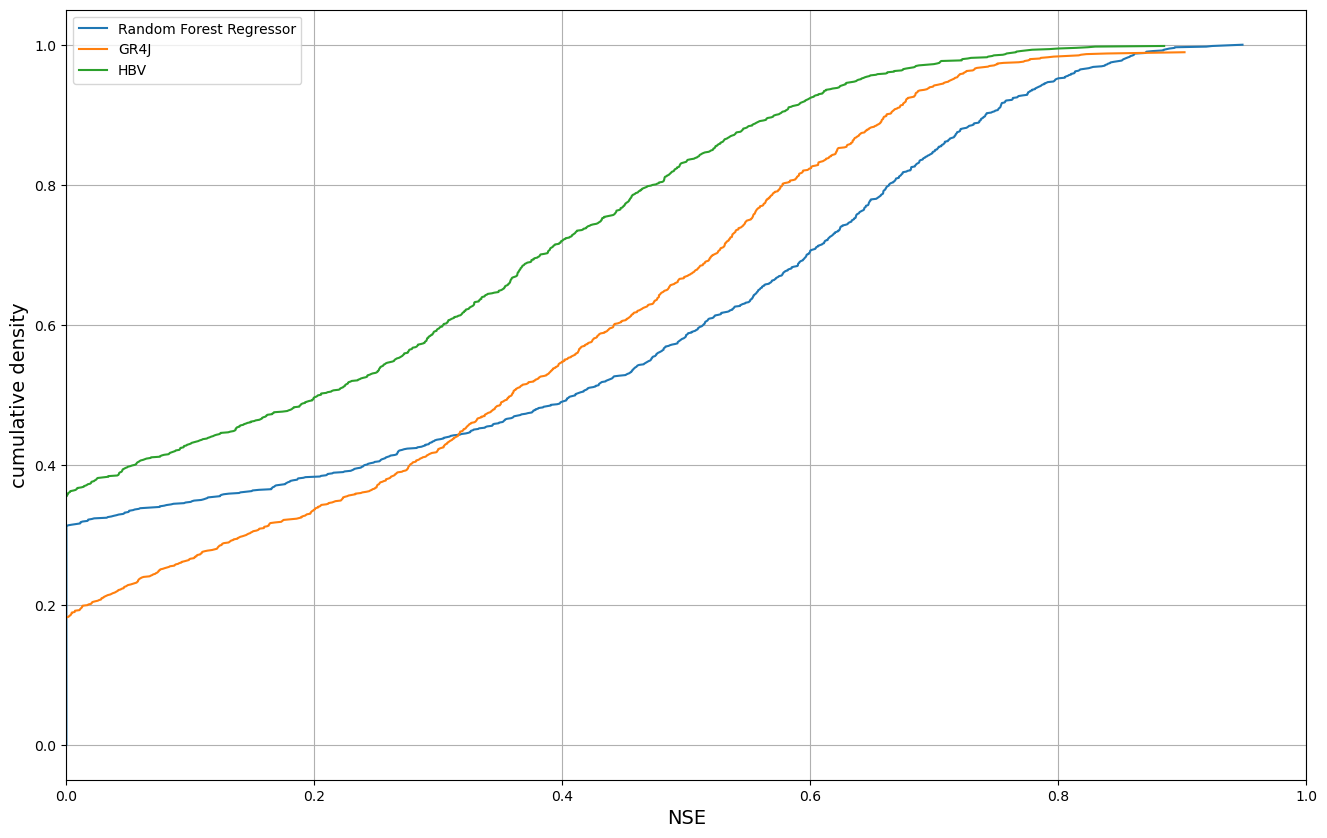

In [339]:
def ecdf(x: np.ndarray):
    """Calculate empirical cummulative density function
    
    Parameters
    ----------
    x : np.ndarray
        Array containing the data
    
    Returns
    -------
    x : np.ndarray
        Array containing the sorted metric values
    y : np.ndarray]
        Array containing the sorted cdf values
    """
    xs = np.sort(x)
    ys = np.arange(1, len(xs) + 1) / float(len(xs))
    return xs, ys


fig, ax = plt.subplots(figsize=(16,10))

for name, fil in {'Random Forest Regressor':era5_file['NSE'],
                  'GR4J': res_gr4j['NSE'],
                  'HBV': res_hbv['NSE']}.items():
    bin_, cdf_ = ecdf(fil)
    plt.plot(bin_, cdf_,
            label=f'{name}');
    ax.set_xlim(0, 1)
    ax.grid(True)
    ax.legend(loc='upper left')
    ax.set_xlabel('NSE', fontsize=14)
    ax.set_ylabel('cumulative density', fontsize=14);

In [333]:
hbv_1 = pd.read_csv('../conceptual_runs/res_hbv.csv')
hbv_2 = pd.read_csv('../conceptual_runs/res_hbv_2.csv')
res_hbv = pd.concat([hbv_1, hbv_2]).reset_index(drop=True)
res_hbv.to_csv('../conceptual_runs/final_hbv.csv', index=False)

gr4j_1 = pd.read_csv('../conceptual_runs/res_gr4j.csv')
gr4j_2 = pd.read_csv('../conceptual_runs/res_gr4j_2.csv')
res_gr4j = pd.concat([gr4j_1, gr4j_2]).reset_index(drop=True)
res_gr4j.to_csv('../conceptual_runs/final_gr4j.csv', index=False)

### Russia geom

In [5]:
test_gauges = pd.read_csv('./data/basins_test.txt', names=['gauge_id'])
test_gauges['gauge_id'] = test_gauges['gauge_id'].astype(str)
train_gauges = pd.read_csv('./data/basins_train.txt', names=['gauge_id'])
train_gauges['gauge_id'] = train_gauges['gauge_id'].astype(str)
val_gauges = pd.read_csv('./data/basins_val.txt', names=['gauge_id'])
val_gauges['gauge_id'] = val_gauges['gauge_id'].astype(str)

for i, val in enumerate(gauges_file.loc[:, 'gauge_id']):
    
    if val in test_gauges['gauge_id'].values:
        gauges_file.loc[i, 'status'] = 'test'
    elif val in train_gauges['gauge_id'].values:
        gauges_file.loc[i, 'status'] = 'train'
    elif val in val_gauges['gauge_id'].values:
        gauges_file.loc[i, 'status'] = 'val'
    else:
        gauges_file.loc[i, 'status'] = np.NaN
gauges_file

gauge_id                         name_ru  \
0        9002              р.Енисей - г.Кызыл   
1        9022         р.Енисей - пос.Никитино   
2        9053          р.Енисей - пос.Базаиха   
3        9112  р.Большой Енисей - с.Тоора-Хем   
4        9115    р.Большой Енисей - пос.Сейба   
...       ...                             ...   
2075    11056            р.Иртыш - г.Тобольск   
2076    11061      р.Иртыш - г.Ханты-Мансийск   
2077    11801              р.Обь - г.Салехард   
2078    10031             р.Обь - с.Белогорье   
2079     2027               р.Берш - с.Пущино   

                              name_en     new_area  ais_dif  \
0                  r.Enisej - g.Kyzyl   115263.989    0.230   
1             r.Enisej - pos.Nikitino   184499.118    1.373   
2              r.Enisej - pos.Bazaiha   302690.417    0.897   
3     r.Bol'shoj Enisej - s.Toora-Hem    15448.834    0.969   
4       r.Bol'shoj Enisej - pos.Sejba    44934.891    0.751   
...                               ...          ...      ...   
2075            r.Irtysh - g.Tobol'sk  1540451.386    2.697   
2076      r.Irtysh - g.Hanty-Mansijsk  1694019.131    2.668   
2077               r.Ob' - g.Salehard  3004250.818    1.839   
2078              r.Ob' - s.Belogor'e  2738297.601    1.795   
2079             r.Bersh - s.Puschino       67.694    3.843   

                                               geometry status  
0     POLYGON ((96.87792 53.72792, 96.87792 53.72708...    NaN  
1     POLYGON ((96.87792 53.72708, 96.88042 53.72708...    NaN  
2     POLYGON ((92.38292 56.11042, 92.38292 56.10958...    NaN  
3     POLYGON ((97.07125 52.71625, 97.07125 52.71542...  train  
4     POLYGON ((96.87792 53.72708, 96.88042 53.72708...  train  
...                                                 ...    ...  
2075  POLYGON ((65.28125 59.37208, 65.28125 59.37125...    NaN  
2076  POLYGON ((62.66375 61.80542, 62.66542 61.80542...    NaN  
2077  POLYGON ((66.69042 66.42875, 66.69042 66.42792...    NaN  
2078  POLYGON ((74.80958 63.03958, 74.80958 63.03875...    NaN  
2079  POLYGON ((157.97708 54.05625, 157.97792 54.056...    val  

[2080 rows x 7 columns]

<class 'geopandas.geodataframe.GeoDataFrame'>


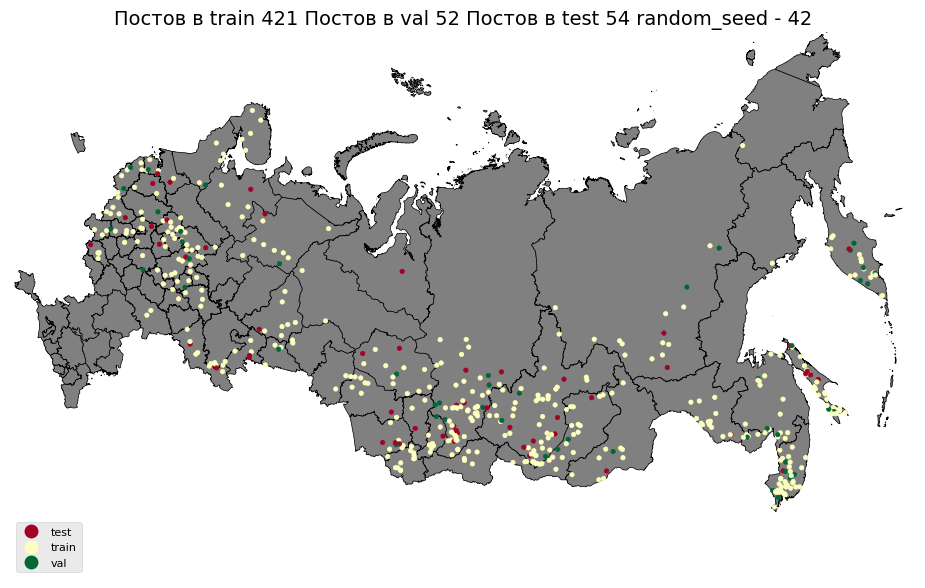

In [143]:
gauges_fig = russia_plots(gdf_to_plot=gauges_file.dropna(),
                          basemap_data=basemap_data,
                          distinction_col='status',
                          title_text=f"""Постов в train {len(train_gauges)}\
 Постов в val {len(val_gauges)}\
 Постов в test {len(test_gauges)}\
 random_seed - 42""",
                          just_points=True);


In [5]:
q_obs = {'full': list(),
         'partial': list(),
         'empty': list()}
h_obs = {'full': list(),
         'partial': list(),
         'empty': list()}

def nan_fractor(df_col: pd.Series):
    nan_frac = df_col.isna().sum() / len(df_col)
    return nan_frac

nc_cond = [file.split('/')[-1][:-3] for file
           in glob.glob('../geo_data/great_db/nc_concat/*.nc')]

for file in glob.glob('../geo_data/great_db/ais_data/q_h/*.csv'):
    gauge_id = file.split('/')[-1][:-4]
    if gauge_id in nc_cond:
        test = pd.read_csv(file, index_col='date')
        lvls = test[['lvl_sm', 'lvl_mbs']]
        dschrg = test[['q_cms_s', 'q_mm_day']]
        
        fraction_of_nan_q = dschrg['q_cms_s'].isna().sum() / len(dschrg)
        
        if fraction_of_nan_q == 0.0:
            q_obs['full'].append(gauge_id)
        elif fraction_of_nan_q <= 0.25:
            q_obs['partial'].append(gauge_id)
        elif fraction_of_nan_q > 0.25:
            q_obs['empty'].append(gauge_id)
            
        fraction_of_nan_h = lvls['lvl_mbs'].isna().sum() / len(lvls)
        
        if fraction_of_nan_h == 0.0:
            h_obs['full'].append(gauge_id)
        elif fraction_of_nan_h <= 0.25:
            h_obs['partial'].append(gauge_id)
        elif fraction_of_nan_h > 0.25:
            h_obs['empty'].append(gauge_id)
    else:
        continue


In [5]:
[len(val) for val in h_obs.values()]

[1482, 368, 36]

In [7]:
partial_gages = pd.read_csv('../conclusions/tables/partial_gages.csv')
partial_gages['gauge_id'] = partial_gages['gauge_id'].astype(str)


### Plots for discharges

In [25]:
partial_gages

gauge_id                                     geometry       NSE_tft   
0      49001                    POINT (31.41892 65.79876) -8.919741e+06  \
1      49048                     POINT (30.3404 65.20325)  7.773879e-01   
2      49055                    POINT (32.38368 64.15004) -1.204348e+04   
3      49103                     POINT (33.06936 63.5483) -1.910180e+03   
4      71018                    POINT (31.15858 69.51481)  5.218575e-01   
..       ...                                          ...           ...   
299     1538  POINT (150.7810374473952 59.63836163922947)  6.709279e-01   
300    71267                    POINT (33.23896 67.83501)  5.993965e-01   
301    76704                      POINT (59.8797 56.6092)  6.065795e-01   
302    76491                    POINT (54.67846 55.13715)  5.545251e-01   
303     9396  POINT (93.42255646890733 61.02100601220244)  8.089356e-01   

     NSE_lstm  
0   -2.014809  
1    0.535698  
2   -0.516832  
3    0.646983  
4    0.404889  
..        ...  
299  0.438461  
300  0.471202  
301 -0.301125  
302 -0.199085  
303 -0.013745  

[304 rows x 4 columns]

 Full discharge coverage 1180 gauges
 From 75% to 100% discharge coverage 434 gauges
 Less than 75% discharge coverage 272 gauges


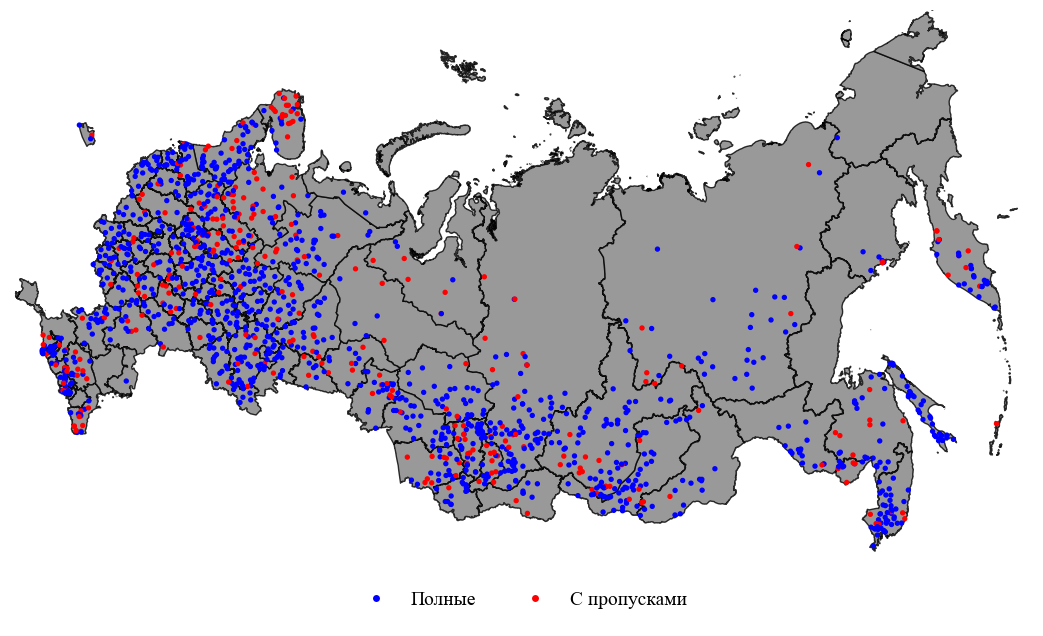

In [10]:
gauges_file = gpd.read_file('../geo_data/great_db/geometry/russia_gauges.gpkg')
for i, val in enumerate(gauges_file.loc[:, 'gauge_id']):
    
    if val in q_obs['partial']:
        gauges_file.loc[i, 'status'] = 'С пропусками'
    elif val in q_obs['full']:
        gauges_file.loc[i, 'status'] = 'Полные'
    # elif val in q_obs['empty']:
    #     gauges_file.loc[i, 'status'] = '<75%'
gauges_file[gauges_file['status'] == 'С пропусками'] = gauges_file[gauges_file['status'] == 'С пропусками'][gauges_file[gauges_file['status'] == 'С пропусками']['gauge_id'].isin(partial_gages['gauge_id'])]
gauges_fig = russia_plots(gdf_to_plot=gauges_file.dropna(),
                          basemap_data=basemap_data,
                          distinction_col='status',
                          figsize=(15, 8),
                          cmap_name='bwr',
                          title_text='',
                          just_points=True)
print(f"""\
 Full discharge coverage {len(q_obs['full'])} gauges\n\
 From 75% to 100% discharge coverage {len(q_obs['partial'])} gauges\n\
 Less than 75% discharge coverage {len(q_obs['empty'])} gauges""")

gauges_fig.savefig('../conclusions/images/partial_full_gages.png',
                   bbox_inches='tight',
                   dpi=650)

In [10]:
gauges_file[gauges_file['status'] == '75-100%'].to_file('../geo_data/great_db/geometry/gauges_partial_q.gpkg')

### Levels

<class 'geopandas.geodataframe.GeoDataFrame'>


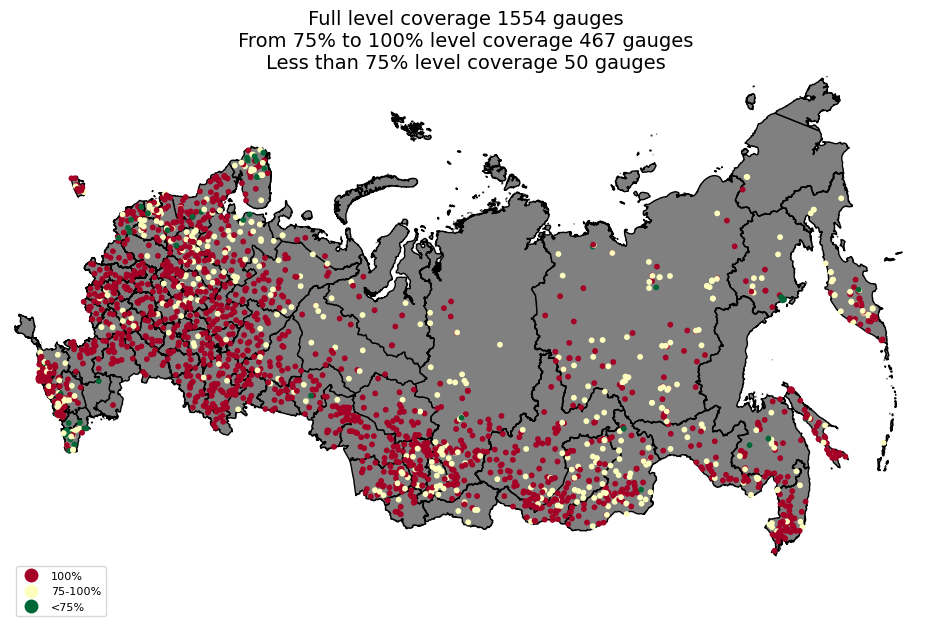

In [23]:
gauges_file = gpd.read_file('../geo_data/great_db/geometry/russia_gauges.gpkg')

for i, val in enumerate(gauges_file.loc[:, 'gauge_id']):
    
    if val in h_obs['full']:
        gauges_file.loc[i, 'status'] = '100%'
    elif val in h_obs['partial']:
        gauges_file.loc[i, 'status'] = '75-100%'
    elif val in h_obs['empty']:
        gauges_file.loc[i, 'status'] = '<75%'

gauges_fig = russia_plots(gdf_to_plot=gauges_file,
                          basemap_data=basemap_data,
                          distinction_col='status',
                          title_text=f"""\
 Full level coverage {len(h_obs['full'])} gauges\n\
 From 75% to 100% level coverage {len(h_obs['partial'])} gauges\n\
 Less than 75% level coverage {len(h_obs['empty'])} gauges""",
                          just_points=True);


### Check model quality

In [ ]:
era5_land_file, nse_median = metric_viewer(
    metric_col='NSE',
    gauges_file=gauges_file,
    metric_csv='../test_meteo_input/runs_static/era5L_static_prcp_0704_170903/test/model_epoch021/test_metrics.csv')
gauges_fig = russia_plots(gdf_to_plot=era5_land_file,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(era5_land_file)} водосборов = {nse_median:.3f}""");

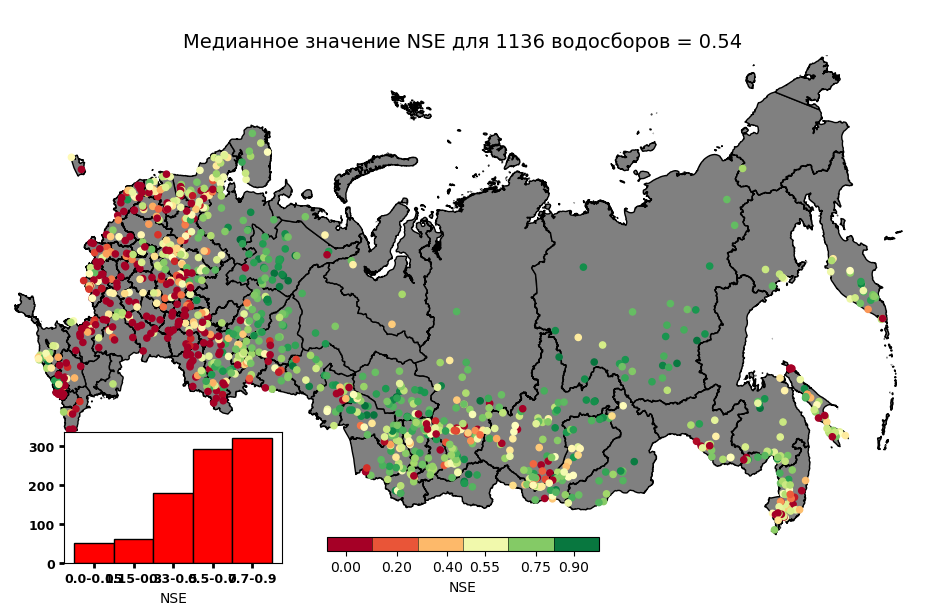

In [17]:
gpcp_file, nse_median = metric_viewer(
    '../test_meteo_input/runs_q_cms/gpcp_prcp_3003_063422/test/model_epoch042/test_metrics.csv')
gauges_fig = russia_plots(gdf_to_plot=gpcp_file,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(gpcp_file)} водосборов = {nse_median:.2f}""");

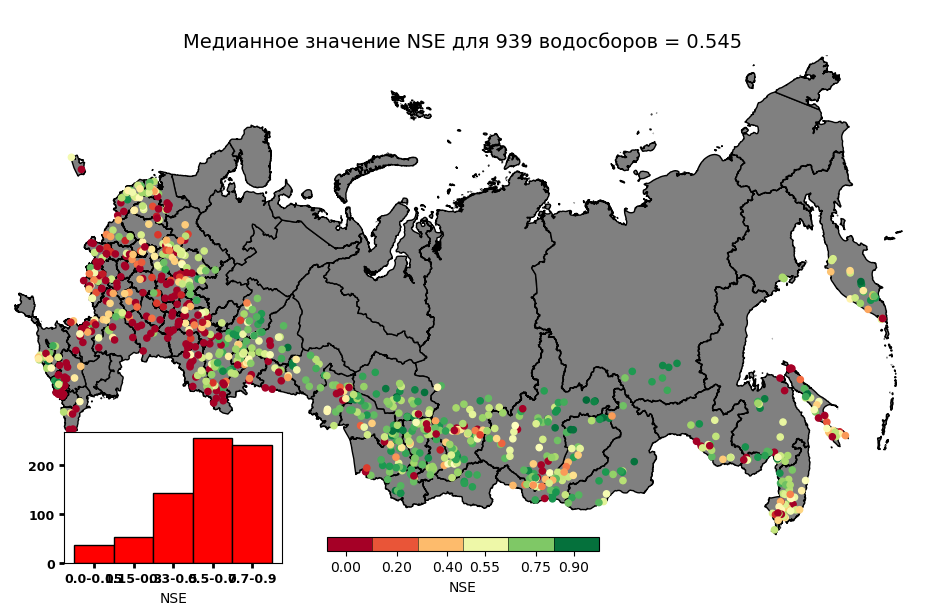

In [20]:
imerg_file, nse_median = metric_viewer(
    '../test_meteo_input/runs_q_cms/imerg_prcp_3003_135405/test/model_epoch042/test_metrics.csv')
gauges_fig = russia_plots(gdf_to_plot=imerg_file,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(imerg_file)} водосборов = {nse_median:.3f}""");

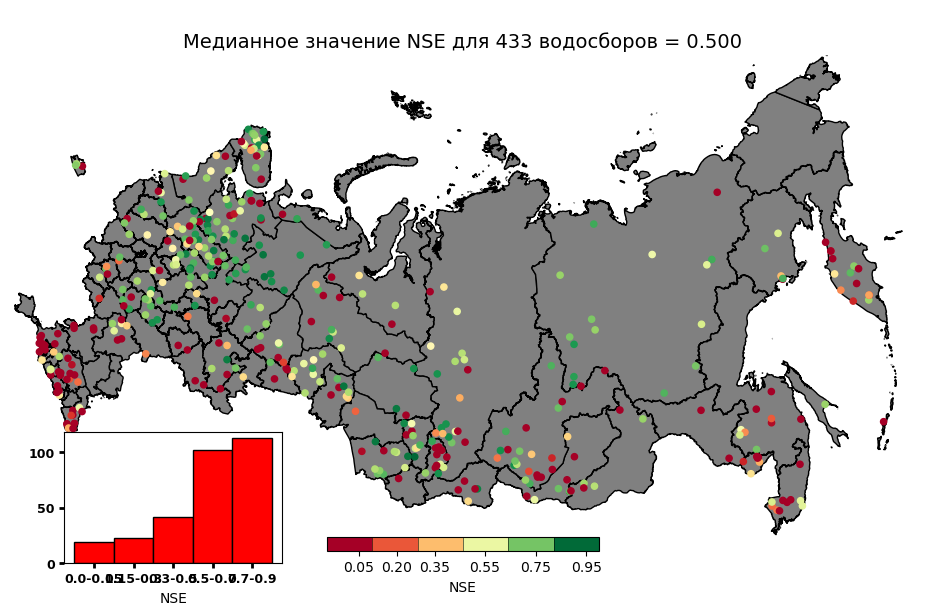

In [3]:
era5_mm, nse_median = metric_viewer(
    gauges_file=gauges_file,
    metric_col='NSE',
    metric_csv='../test_meteo_input/runs_blind/era5L_static_CellsBlind_2004_130807/test/model_epoch024/test_metrics.csv')
gauges_fig = russia_plots(gdf_to_plot=era5_mm,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(era5_mm)} водосборов = {nse_median:.3f}""");

Медианное значение NSE для 433 водосборов = 0.437


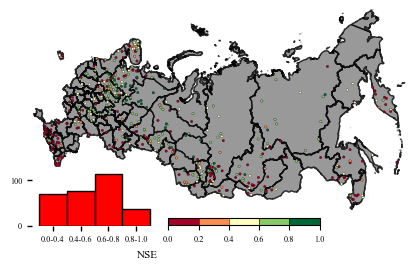

In [13]:
era5_file, nse_median = metric_viewer(
    metric_col='NSE',
    gauges_file=gauges_file,
    metric_csv='/workspaces/my_dissertation/test_meteo_input/runs_blind/era5L_static_CellsBlind_2004_130807/test/model_epoch024/test_metrics.csv')
gauges_fig = russia_plots(gdf_to_plot=era5_file,
                          basemap_data=basemap_data,
                          cmap_name='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text='')
print(f"""Медианное значение NSE для {len(era5_file)} водосборов = {nse_median:.3f}""")
gauges_fig.savefig('./into_dissertation/blind_forecast.png',
                   dpi=650)

### Static ERA5-Land

In [61]:
era5_file, nse_median = metric_viewer(metric_csv='/workspaces/my_dissertation/conclusions/tables/DELETE_NSE_HBV.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)

Медианное значение NSE для 393 водосборов = 0.513


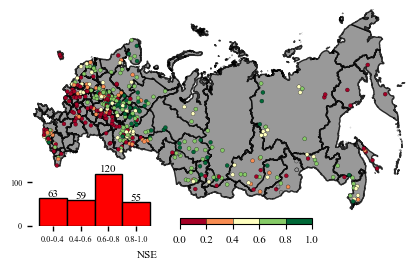

In [62]:
gauges_fig = russia_plots(gdf_to_plot=era5_file,
                          basemap_data=basemap_data,
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True)
print(f"""Медианное значение NSE для {len(era5_file)} водосборов = {nse_median:.3f}""")

Медианное значение NSE для 393 водосборов = 0.632


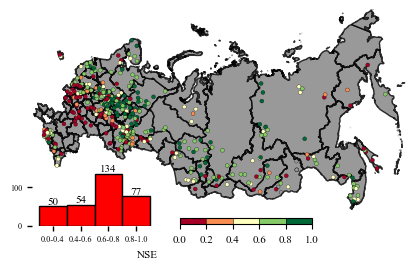

In [60]:
gauges_fig = russia_plots(gdf_to_plot=era5_file,
                          basemap_data=basemap_data,
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True)
print(f"""Медианное значение NSE для {len(era5_file)} водосборов = {nse_median:.3f}""")

In [ ]:
era5_file, nse_median = metric_viewer(metric_csv='/workspaces/my_dissertation/conclusions/tables/DELETE_NSE.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)

Медианное значение NSE для 265 водосборов = 0.203


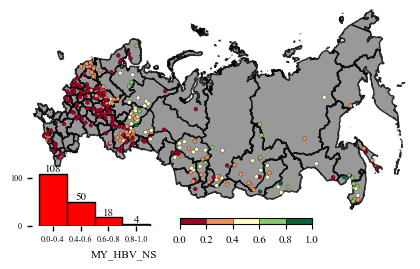

In [56]:
gauges_fig = russia_plots(gdf_to_plot=era5_file,
                          basemap_data=basemap_data,
                          metric_col='MY_HBV_NS',
                          distinction_col='',
                          with_histogram=True)
print(f"""Медианное значение NSE для {len(era5_file)} водосборов = {nse_my_hbv:.3f}""")
# gauges_fig.savefig('./into_dissertation/рисунок.tiff',
#                    dpi=650, bbox_inches='tight')

### No-Static ERA5-Land

In [1]:
era5_file, nse_median = metric_viewer(metric_csv='/workspaces/my_dissertation/test_meteo_input/runs_no_static/era5Land_prcp_0604_111347/test/model_epoch030/test_metrics.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)
gauges_fig = russia_plots(gdf_to_plot=era5_file,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(era5_file)} водосборов = {nse_median:.2f}""");
gauges_fig.savefig('./example.tiff',
                   dpi=650)

NameError: name 'metric_viewer' is not defined

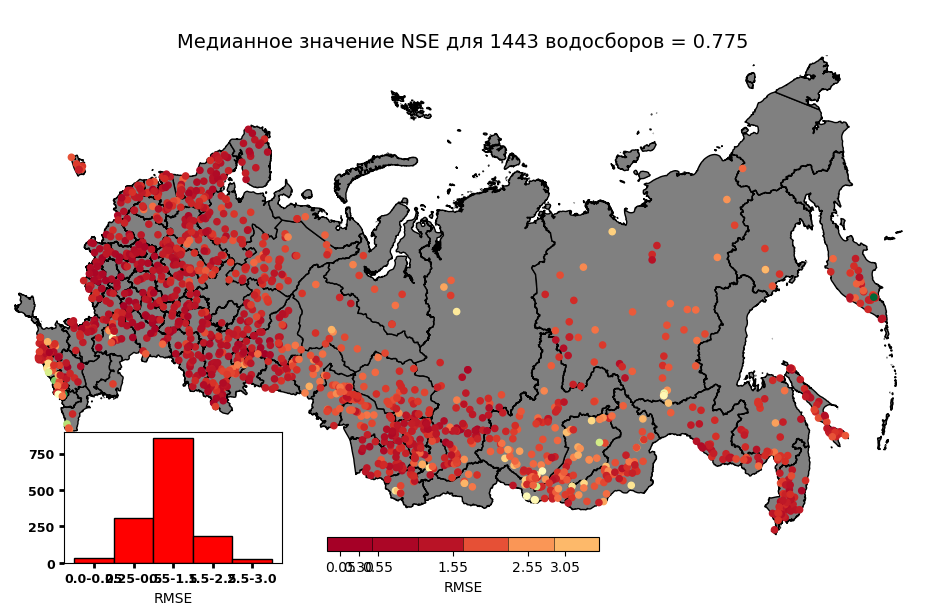

In [21]:
mswep_h_mbs, nse_median = metric_viewer(
    gauges_file=gauges_file,
    metric_csv='/workspaces/my_dissertation/test_meteo_input/runs_h/mswep_lvl_mbs_0304_203329/test/model_epoch021/test_metrics.csv',
    metric_col='RMSE')

gauges_fig = russia_plots(gdf_to_plot=mswep_h_mbs,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='RMSE',
                          list_of_limits=[0.00, 0.25, 0.50, 1.50, 2.50, 3.00],
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(mswep_h_mbs)} водосборов = {nse_median:.3f}""");

In [3]:
xr.open_dataset('../geo_data/great_db/nc_all_h/10002.nc')

<xarray.Dataset>
Dimensions:     (date: 4749)
Coordinates:
  * date        (date) datetime64[ns] 2008-01-01 2008-01-02 ... 2020-12-31
    gauge_id    object ...
Data variables: (12/23)
    lvl_sm      (date) float64 ...
    q_cms_s     (date) float64 ...
    lvl_mbs     (date) float64 ...
    q_mm_day    (date) float64 ...
    t_max_e5l   (date) float64 ...
    t_max_e5    (date) float64 ...
    ...          ...
    SMroot      (date) float64 ...
    Ew          (date) float64 ...
    Ei          (date) float64 ...
    S           (date) float64 ...
    E           (date) float64 ...
    Ep          (date) float64 ...

### View BAD results

In [ ]:
for gauge in [gauge.split('/')[-1][:-3]
              for gauge in glob.glob('../geo_data/great_db/nc_all_q/*.nc')]:

    area = ws_file.loc[gauge, 'new_area']
    results = xr.open_dataset(f'../geo_data/great_db/nc_all_q/{gauge}.nc').drop('gauge_id').to_dataframe()[['lvl_sm', 'q_cms_s', 'q_mm_day', 'prcp_e5', 'prcp_e5l', 'prcp_mswep', 'prcp_gpcp']]
    results.to_csv(f'./recovery/{gauge}.csv')
    fig = results[['q_mm_day']].plot(
            figsize=(15, 10),
            fontsize=18).get_figure();
    plt.title(f'{gauge} for catchment with area of {area:.3f}',
              fontsize=20)
    fig.savefig(f"./images/{gauge}.png")
    # plt.show()

### Outlier remover

In [51]:
example_file = pd.read_csv('./recovery/10058.csv',
                           index_col='date')
example_file.index = pd.to_datetime(example_file.index)
example_file

lvl_sm  q_cms_s    q_mm_day   prcp_e5  prcp_e5l  prcp_mswep  \
date                                                                      
2008-01-01    25.0    17.00  100.177329  0.001252  0.004483    0.000000   
2008-01-02    24.0    16.00   94.284545  0.000000  0.003494    0.000000   
2008-01-03    17.0    16.00   94.284545  2.190799  1.011411    0.126885   
2008-01-04    16.0    16.00   94.284545  1.057222  1.675332    0.126885   
2008-01-05    16.0    16.00   94.284545  0.465194  0.252440    0.348934   
...            ...      ...         ...       ...       ...         ...   
2020-12-27    34.0     0.15    0.883918  0.006840  0.027936    0.000000   
2020-12-28    34.0     0.15    0.883918  0.000000  0.001886    0.031721   
2020-12-29    34.0     0.15    0.883918  0.000000  0.002033    0.000000   
2020-12-30    34.0     0.14    0.824990  1.275203  0.672187    0.348934   
2020-12-31    33.0     0.14    0.824990  2.564995  3.084454         NaN   

            prcp_gpcp  
date                   
2008-01-01   0.000000  
2008-01-02   0.000000  
2008-01-03   0.567415  
2008-01-04   0.000000  
2008-01-05   1.233340  
...               ...  
2020-12-27   0.000000  
2020-12-28   0.000000  
2020-12-29   0.000000  
2020-12-30   0.429617  
2020-12-31   4.982376  

[4749 rows x 7 columns]

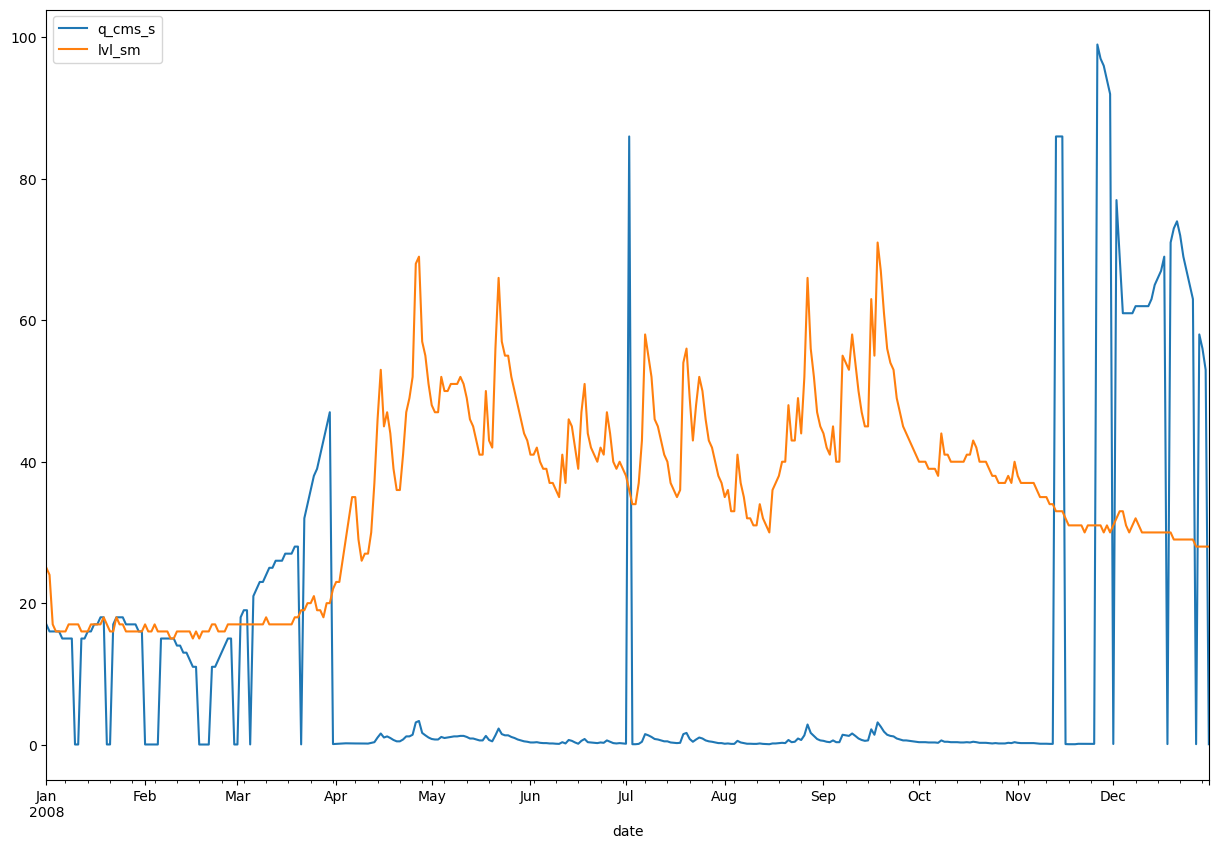

In [64]:
example_file.loc['2008', ['q_cms_s', 'lvl_sm']].plot(figsize=(15, 10));

### Meteo correlation

In [33]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr


def get_r2(df,
           frequency: str,
           prcp_col: str,
           hydro_col: str = 'q_mm_day'):
    df = df.groupby(pd.Grouper(freq=frequency)).sum()
    df = pd.concat([df[prcp_col], df[hydro_col].shift(0)],
                   axis=1).dropna()
    return pearsonr(x=df[hydro_col],
                    y=df[prcp_col])
    
test_df = xr.open_dataset('../geo_data/great_db/nc_all_q/10059.nc')
test_df = test_df.to_dataframe()[['q_cms_s', 'q_mm_day', 'lvl_sm',
                                  'prcp_e5', 'prcp_e5l',
                                  'prcp_gpcp', 'prcp_imerg',
                                  'prcp_mswep']]
get_r2(df=test_df,
       frequency='1D',
       prcp_col='prcp_mswep',
       hydro_col='q_mm_day')[0]

0.31937697786704483

In [ ]:
res_df = list()
for file in tqdm(glob.glob('../geo_data/great_db/nc_all_q/*.nc')):
    
    gauge_id = file.split('/')[-1][:-3]
    test_df = xr.open_dataset(file)
    test_df = test_df.to_dataframe()[['q_cms_s', 'q_mm_day', 'lvl_sm',
                                      'prcp_e5', 'prcp_e5l',
                                      'prcp_gpcp', 'prcp_imerg',
                                      'prcp_mswep']]

    res_df.append(pd.DataFrame({prcp_col: get_r2(df=test_df,
                                frequency='1D',
                                prcp_col=prcp_col,
                                hydro_col='q_mm_day')[0]
    for prcp_col in ['prcp_e5', 'prcp_e5l',
                     'prcp_gpcp', 'prcp_imerg',
                     'prcp_mswep']},
                               index=[gauge_id]))
res_df = pd.concat(res_df)
res_df.index.name = 'gauge_id'

In [34]:
res_df

prcp_e5  prcp_e5l  prcp_gpcp  prcp_imerg  prcp_mswep
gauge_id                                                       
10620     0.023689  0.023284  -0.010829    0.023076    0.019003
4197      0.089042  0.090665   0.047455   -0.007693    0.085626
8306      0.302196  0.302414   0.257192    0.247418    0.273573
78614    -0.022609 -0.022651  -0.022767   -0.025705   -0.003252
5287      0.126174  0.126194   0.087967    0.091244    0.111467
...            ...       ...        ...         ...         ...
72660    -0.042199 -0.042254  -0.030826   -0.028795   -0.048799
75576    -0.018645 -0.018682  -0.023123   -0.023089   -0.032533
83288     0.215020  0.213392   0.086547    0.061690    0.198657
4012           NaN  0.081573   0.037686         NaN         NaN
3210      0.058668  0.058628   0.037376         NaN    0.036069

[1114 rows x 5 columns]

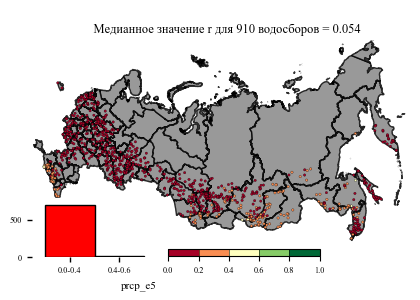

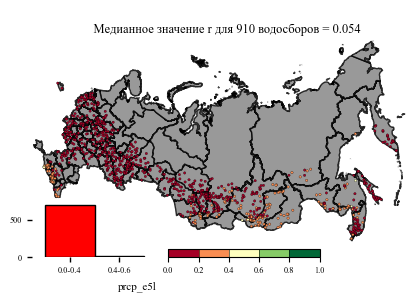

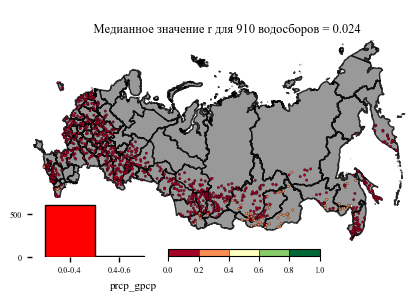

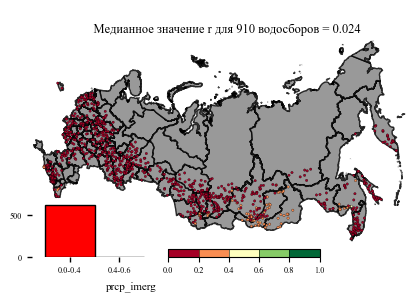

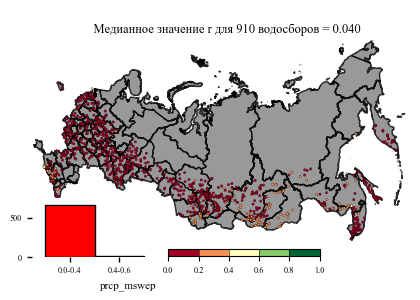

In [35]:
geom_r2 = gauges_file.set_index('gauge_id').join(res_df).dropna()
for prcp_col in ['prcp_e5', 'prcp_e5l',
                 'prcp_gpcp', 'prcp_imerg',
                 'prcp_mswep']:

    r_median = geom_r2[prcp_col].median()
    gauges_fig = russia_plots(gdf_to_plot=geom_r2,
                            basemap_data=basemap_data,
                            cmap_name='RdYlGn',
                            metric_col=prcp_col,
                            distinction_col='',
                            with_histogram=True,
                            title_text=f"""
    Медианное значение r для {len(geom_r2)} водосборов = {r_median:.3f}""");

### Meteo plots

In [6]:
from pathlib import Path
path_to_store = Path('./meteo_visualisations/')
path_to_store.mkdir(exist_ok=True, parents=True)
from typing import Tuple

def read_maurer(maurer_path: Path, basin: str) -> Tuple[pd.DataFrame, float]:
    """[summary]

    Args:
        basin (str): [description]

    Raises:
        RuntimeError: [description]

    Returns:
        Tuple[pd.DataFrame, float]: [description]
    """

    files = list(maurer_path.glob('**/*_forcing_leap.txt'))
    file_path = [f for f in files if f.name[:8] == basin]
    if len(file_path) == 0:
        raise RuntimeError(f'No file for Basin {basin} at {file_path}')
    else:
        file_path = file_path[0]

    df = pd.read_csv(file_path, sep='\s+', header=3)
    dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/" + df.Day.map(str))
    df['date'] = pd.to_datetime(dates, format="%Y-%m-%d")
    df = df.set_index('date', drop=True)

    # load area from header
    with open(file_path, 'r') as fp:
        content = fp.readlines()
        area = round(float(content[2]), 2)
        area /= 10**6

    return df, area


In [7]:
gauges = list(area_data.index)

In [ ]:
differ_files = dict()

for gauge in tqdm(gauges):
    # read meteo file
    area = area_data.loc[gauge, 'ws_area']
    meteo_maurer, _ = read_maurer(maurer_path=Path(
        './data/CAMELS/basin_mean_forcing/maurer_extended'
    ),
        basin=gauge)
    meteo_era = pd.read_csv(f'./data/CAMELS/forcings/{gauge}.csv')
    meteo_era['date'] = pd.to_datetime(meteo_era['date'])
    meteo_era = meteo_era.set_index('date', drop=True)

    res_file = meteo_era.join(meteo_maurer)
    res_file = res_file['01/01/1980':'12/31/2008']
    res_file = res_file.rename(columns={'prcp(mm/day)': 'prcp',
                                        'srad(W/m2)': 'srad',
                                        'swe(mm)': 'swe',
                                        'tmax(C)': 'tmax',
                                        'tmin(C)': 'tmin',
                                        'vp(Pa)': 'vp'})

    differ_files[gauge] = res_file[['temp_max', 'tmax', 'temp_min',
                                    'tmin', 'precip', 'prcp']]


def get_mae_prcp(gauge):
    precip, prcp = differ_files[gauge][['precip', 'prcp']].groupby(
        pd.Grouper(freq='1Y')).sum().mean().values

    res = prcp - precip
    area = area_data.loc[gauge, 'ws_area']

    return (precip, prcp, area)


fin_res = pd.DataFrame()
for gauge, val in differ_files.items():

    era, maurer, area = get_mae_prcp(gauge)
    fin_res.loc[gauge, 'area'] = area
    fin_res.loc[gauge, 'prcp_Era'] = era
    fin_res.loc[gauge, 'prcp_Maurer'] = maurer

fin_res['area_gradation'] = pd.cut(fin_res['area'],
                                   bins=[0, 250, 500, 1000, 2000, np.inf],
                                   right=False,
                                   include_lowest=False)
# group_fin = fin_res.groupby('area_gradation').mean()
era_df = pd.DataFrame()
era_df = fin_res[['area', 'prcp_Era']]
era_df = era_df.rename(columns={'prcp_Era': 'prcp'})
era_df.loc[:, 'tag'] = 'ERA5'

maurer_df = pd.DataFrame()
maurer_df = fin_res[['area', 'prcp_Maurer']]
maurer_df.loc[:, 'tag'] = 'Maurer'
maurer_df = maurer_df.rename(columns={'prcp_Maurer': 'prcp'})

maurer_vs_era = pd.concat([era_df, maurer_df]).reset_index(drop=True)


In [ ]:
ws = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')

def lim_definer(area: float):

    lim_1, lim_2, lim_3, lim_4 = 100, 2000, 10000, 50000

    if area < lim_1:
        return '< 100 $км^2$'
    elif (area >= lim_1) & (area <= lim_2):
        return '100 $км^2$ - 2 000 $км^2$'
    elif (area >= lim_2) & (area <= lim_3):
        return '2 000 $км^2$ - 10 000 $км^2$'
    elif (area >= lim_3) & (area <= lim_4):
        return '10 000 $км^2$ - 50 000 $км^2$'
    else:
        return '> 50 000 $км^2$'


ws['size'] = ws.loc[:, 'new_area'].apply(lambda x: lim_definer(x))
ws['size'] = pd.Categorical(ws['size'], ['< 100 $км^2$',
                                         '100 $км^2$ - 2 000 $км^2$',
                                         '2 000 $км^2$ - 50 000 $км^2$',
                                         '> 50 000 $км^2$'])


plt.figure(figsize=(15, 8))

area_hist = sns.histplot(data=ws,
                         x='size')
#  set the ticks first
area_hist.set_yticks(np.arange(0, 1100, 100));
# set the labels
area_hist.set_yticklabels(np.arange(0, 1100, 100));
area_hist.set_xlabel('Area range')
area_hist.set_ylabel('Number of objects')

area_hist.set_title(f"""Distribution of watersheds areas
for every created geometry""", fontsize=16);


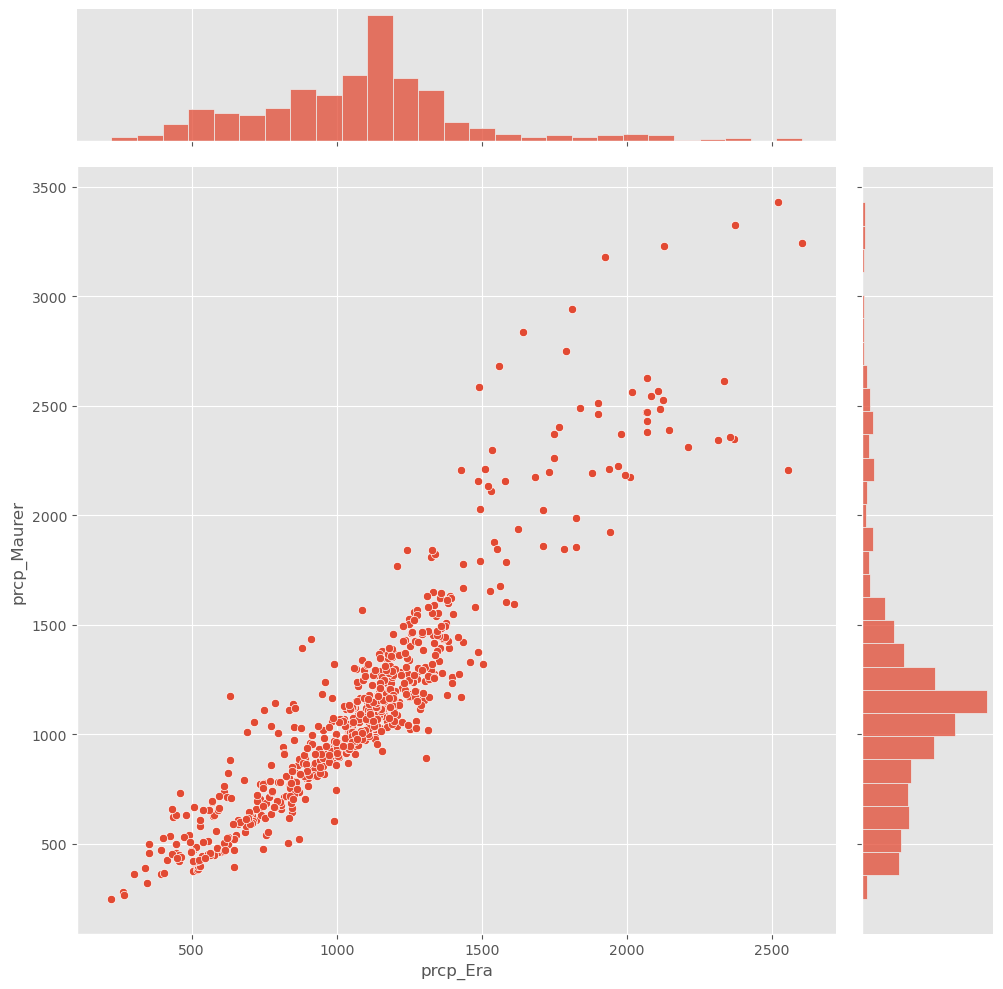

In [8]:
import seaborn as sns
sns.jointplot(data=fin_res, x="prcp_Era", y="prcp_Maurer", height=10);


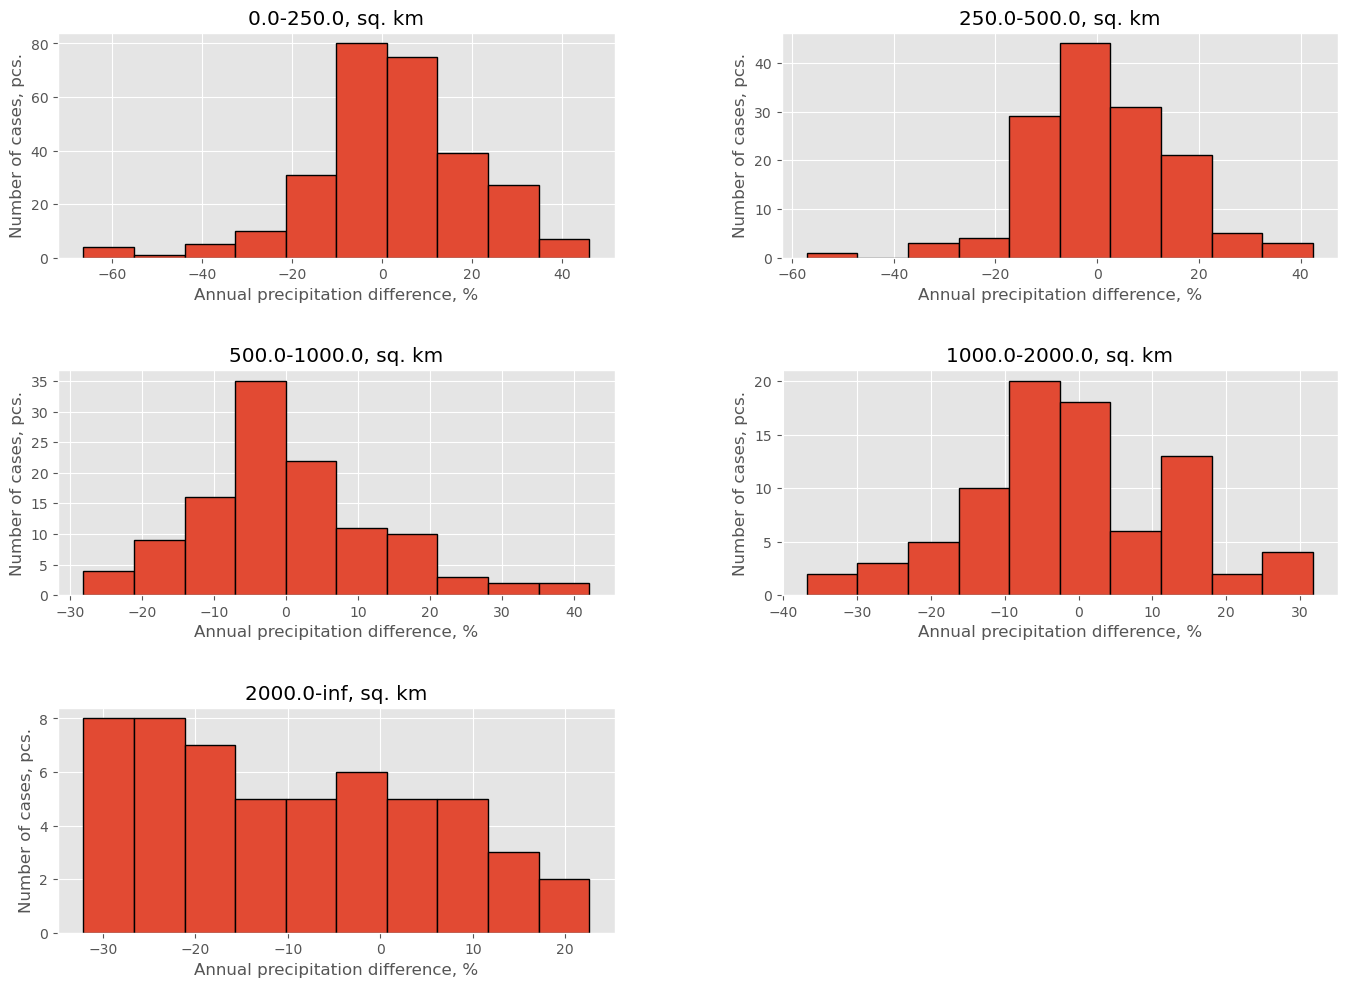

In [11]:
my_hist = fin_res.hist(column='prcp_diff',
                       by='area_gradation',
                       figsize=(16, 12),
                       edgecolor='black', linewidth=1)

xlbl = [str(col)[1:-1].replace(', ', '-')
        for col in np.unique(fin_res['area_gradation'])]
xlbl = [f'{lbl}, sq. km' for lbl in xlbl]

for i, ax in enumerate(my_hist.flatten()[:-1]):
    ax.set_title(xlbl[i])
    ax.set_xlabel("Annual precipitation difference, %")
    ax.set_ylabel('Number of cases, pcs.')
    ax.tick_params(axis='x', labelrotation=0);


In [11]:
from sklearn.metrics import r2_score


def get_r2(precip_df, frequency: str):
    precip_df = precip_df.groupby(pd.Grouper(freq=frequency)).sum()
    return r2_score(y_true=precip_df['prcp'],
                    y_pred=precip_df['precip'])


def value_hist(column_to_plot: str,
               frequency: str,
               xlabel: str):

    fin_res[column_to_plot] = [get_r2(data,
                                      frequency=frequency)
                               for data in differ_files.values()]

    my_hist = fin_res.hist(column=column_to_plot,
                           by='area_gradation',
                           figsize=(16, 12),
                           edgecolor='black', linewidth=1)

    xlbl = [str(col)[1:-1].replace(', ', '-')
            for col in np.unique(fin_res['area_gradation'])]
    xlbl = [f'{lbl}, кв. км' for lbl in xlbl]

    for i, ax in enumerate(my_hist.flatten()[:-1]):
        ax.set_title(xlbl[i])
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Число объектов, шт.')
        ax.tick_params(axis='x', labelrotation=0)


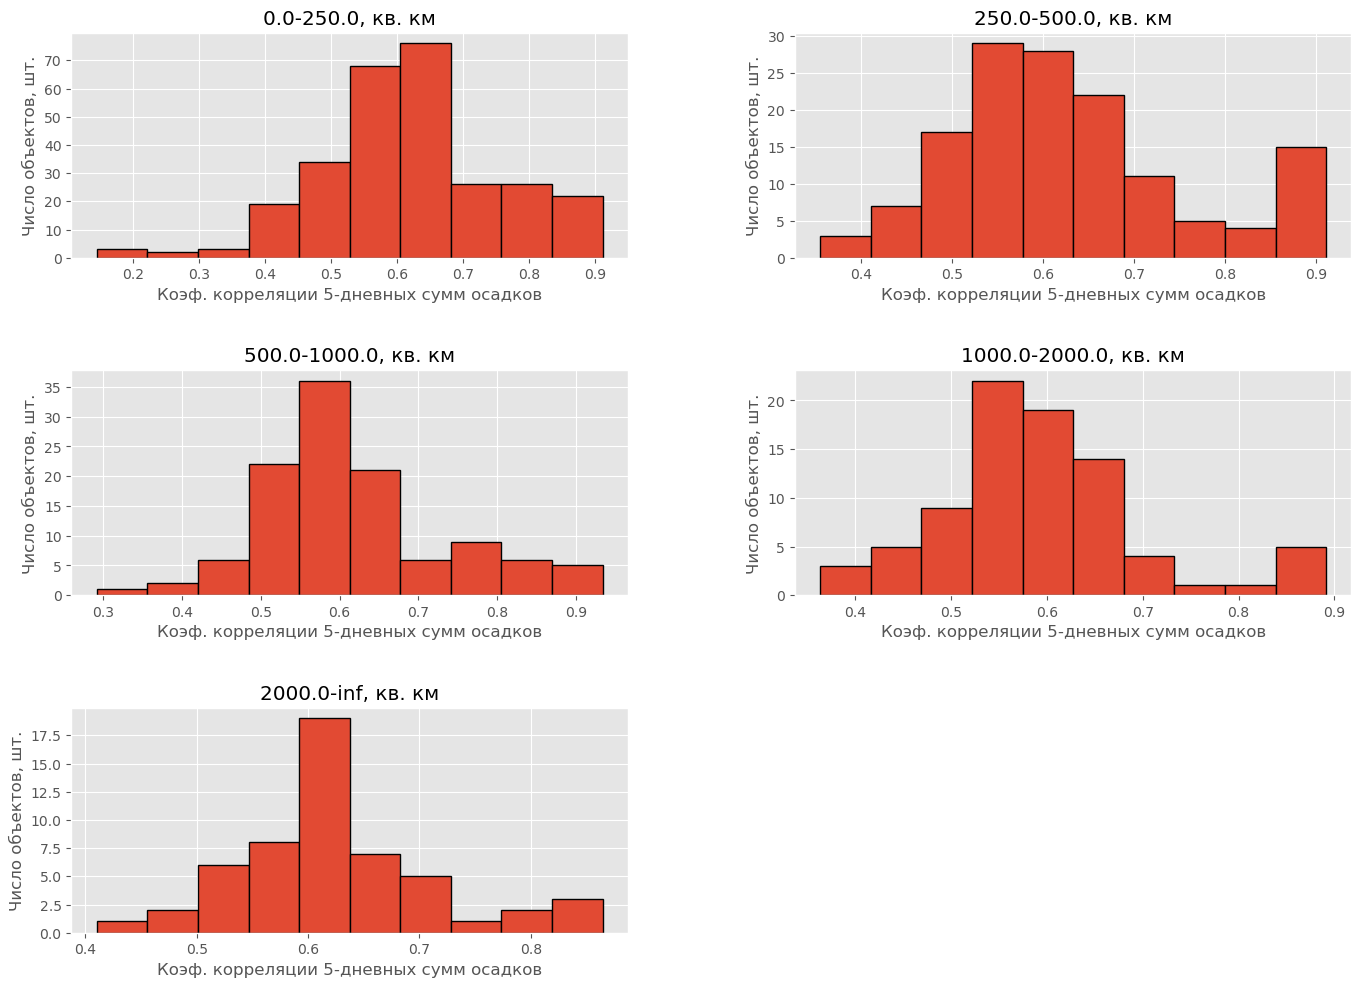

In [12]:
value_hist(column_to_plot='r2_5d',
           frequency='5d',
           xlabel="Коэф. корреляции 5-дневных сумм осадков")

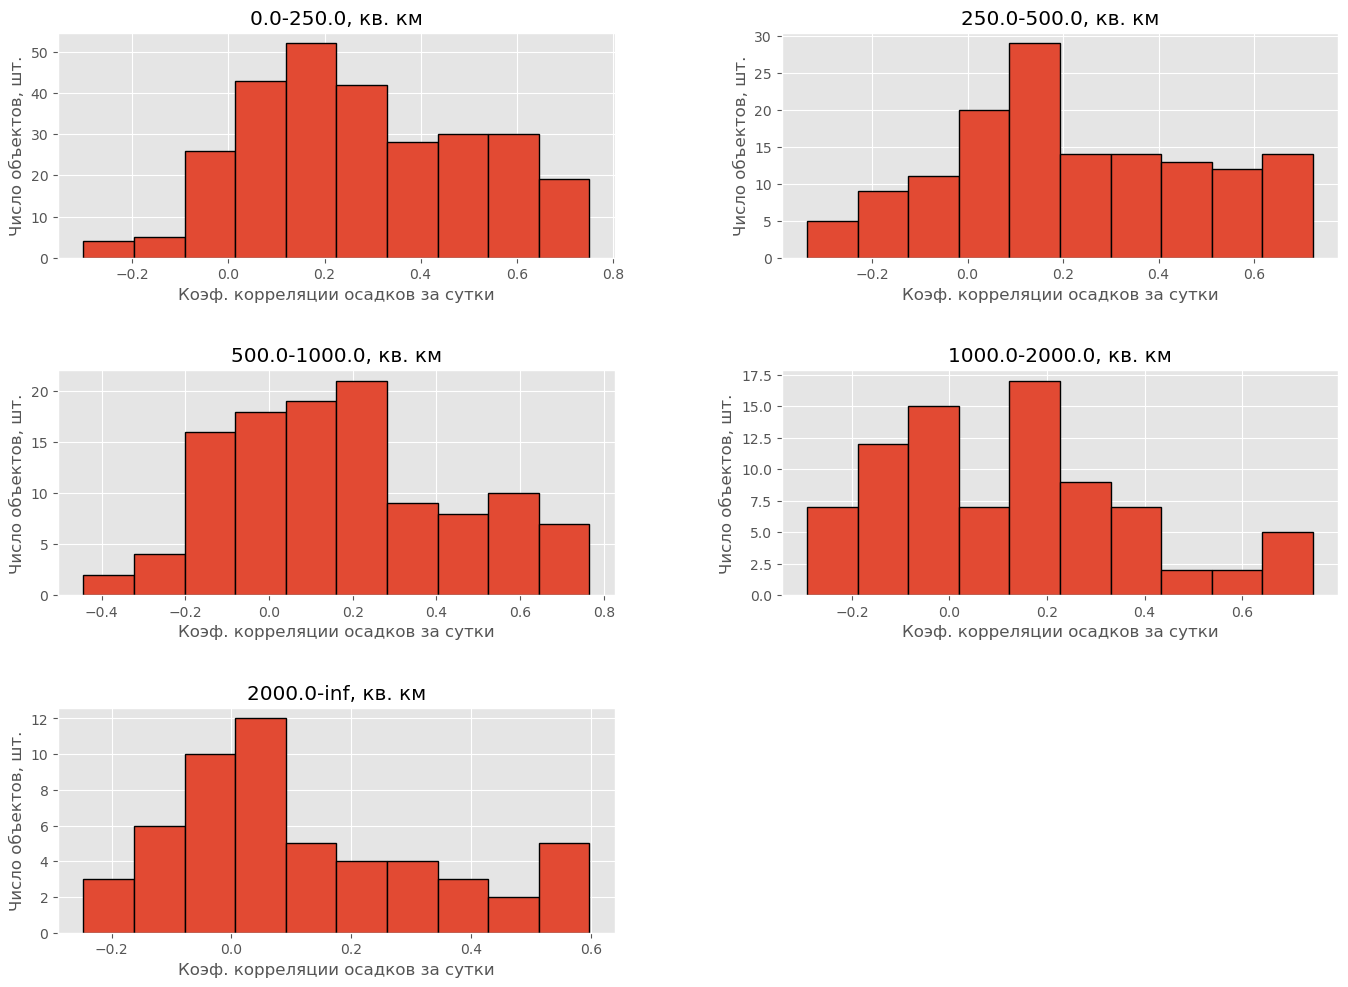

In [13]:
value_hist(column_to_plot='r2_daily',
           frequency='1d',
           xlabel="Коэф. корреляции осадков за сутки")

## Weighted meteo-grid

In [6]:
import random
import sys
sys.path.append('../')
from data_builders.scripts.geom_functions import (create_gdf, polygon_area,
                                                  getSquareVertices,
                                                  poly_from_multipoly,
                                                  find_extent)
from data_builders.scripts.nc_proc import nc_by_extent

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as mticker

import xarray as xr
import dask.config as dask_cfg
from shapely.geometry import Polygon

random.seed(42)

In [18]:
test_geom = ws_file[(800 < ws_file['new_area']) & (ws_file['new_area'] < 1000)]
test_geom = test_geom.reset_index(drop=True)

random_geom = test_geom.loc[random.randint(0, 109), 'geometry']


In [9]:
geom = gpd.read_file('../paper_visualisation/weight_mask/actual_ws.gpkg').loc[0, 'geometry']
example_nc = xr.open_dataset(
    '../geo_data/meteorology/era5/russia/total_precipitation/tp_2007.nc')


In [4]:
example_nc

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 689, latitude: 165)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * longitude  (longitude) float32 19.0 19.25 19.5 19.75 ... 190.5 190.8 191.0
  * latitude   (latitude) float32 82.0 81.75 81.5 81.25 ... 41.5 41.25 41.0
Data variables:
    tp         (time, latitude, longitude) float32 ...

In [13]:
# watershed boundaries geometry as geodataframe
ws_gdf = create_gdf(geom)

with dask_cfg.set(**{'array.slicing.split_large_chunks': True}):
    mask_nc = nc_by_extent(nc=example_nc,
                            shape=geom,
                            grid_res=0.125,
                            dataset='era5')

# get lat, lon which help define area for intersection
nc_lat, nc_lon = mask_nc.lat.values, mask_nc.lon.values
# emulate polygons for grid
polygons = list()
for lat in nc_lat:
    for lon in nc_lon:
        # h = 0.125 as a half of ERA5 resolution
        # phi rotation angle
        polygons.append(Polygon(
            getSquareVertices(mm=(lon, lat),
                              h=0.125,
                              phi=0)))
# create geodataframe from each polygon from emulation
polygons = [create_gdf(poly) for poly in polygons]
# calculate area of watershed to latter comparisons
ws_area = polygon_area(geo_shape=ws_gdf.loc[0, 'geometry'])
# find intersection beetween grid cell and actual watershed
intersected = list()
for polygon in polygons:
    try:
        intersected.append(gpd.overlay(df1=ws_gdf,
                                       df2=polygon,
                                       how='intersection'))
    except KeyError:
        intersected.append(gpd.GeoDataFrame())
# find biggest intersection if it returns MultiPolygon instance
# select biggest Polygon in MultiPolygon
intersected = [create_gdf(
    poly_from_multipoly(section.loc[0, 'geometry']))  # type: ignore
    if len(section) != 0
    else gpd.GeoDataFrame()
    for section in intersected]
# create mask for intersection with net_cdf
inter_mask = np.array([False if section.empty is True
                       else True
                       for section in intersected])
polygon_size = np.sum(inter_mask)
# shape of initial coordindate size
grid_shape = (len(nc_lat), len(nc_lon))

inter_mask = inter_mask.reshape(grid_shape)
inter_mask = xr.DataArray(data=inter_mask,
                          dims=['lat', 'lon'],
                          coords=[nc_lat, nc_lon])
# calculate weights of each intersection correspond to net cdf grid
weights = np.array([0 if section.empty
                    else polygon_area(
                        geo_shape=section.loc[0, 'geometry']) / polygon_area(geo_shape=polygons[0].loc[0, 'geometry'])
                    for section in intersected])
weights = weights.reshape(grid_shape)
# transform to DataArray for calculations
weights = xr.DataArray(data=weights,
                       dims=['lat', 'lon'])
weights.name = 'weights'
weights = weights.where(inter_mask, drop=True)
weights = weights.fillna(0)

poly_weights = pd.concat(polygons).reset_index(drop=True)
poly_weights['weights'] = weights.values.flatten()
poly_weights = gpd.GeoDataFrame(data=poly_weights,
                                geometry='geometry').set_crs(epsg=4326)

In [25]:
res_nc = mask_nc.weighted(weights=weights).sum(
    dim=['time'])['tp'] / polygon_size


In [21]:
(res_nc * 1e3).to_netcdf('../paper_visualisation/weight_mask/example_nc.nc')

In [27]:
res_nc

<xarray.DataArray 'tp' (lat: 2, lon: 5)>
dask.array<truediv, shape=(2, 5), dtype=float64, chunksize=(2, 5), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 29.0 29.25 29.5 29.75 30.0
  * lat      (lat) float32 58.25 58.0

In [30]:
min_lon, max_lon, min_lat, max_lat = find_extent(ws=geom,
                                                 grid_res=0.125,
                                                 dataset='era5')
if 'latitude' in example_nc.dims:
    example_nc = example_nc.rename({'latitude': 'lat', 'longitude': 'lon'})
else:
    pass
example_nc = example_nc.sum(dim=['time'])['tp'] 
masked_nc = example_nc.where(
    example_nc.lat >= min_lat-0.25, drop=True).where(
    example_nc.lat <= max_lat+0.25, drop=True).where(
    example_nc.lon >= min_lon-0.25, drop=True).where(
    example_nc.lon <= max_lon+0.25, drop=True)
(masked_nc * 1e3).to_netcdf('../paper_visualisation/weight_mask/mask_nc.nc')

In [35]:
masked_nc

<xarray.DataArray 'tp' (lat: 4, lon: 7)>
array([[0.6694761 , 0.632006  , 0.6185994 , 0.62996227, 0.62968683,
        0.6243305 , 0.6197216 ],
       [0.73849565, 0.70101386, 0.67566156, 0.64399594, 0.637223  ,
        0.6294862 , 0.62206775],
       [0.727963  , 0.7231056 , 0.6880951 , 0.6487268 , 0.64304245,
        0.63786995, 0.6437211 ],
       [0.71899414, 0.7282267 , 0.70704883, 0.6859656 , 0.6822779 ,
        0.678944  , 0.66865706]], dtype=float32)
Coordinates:
  * lon      (lon) float32 28.75 29.0 29.25 29.5 29.75 30.0 30.25
  * lat      (lat) float32 58.5 58.25 58.0 57.75

In [34]:
masked_nc.sum()

<xarray.DataArray 'tp' ()>
array(18.654366, dtype=float32)

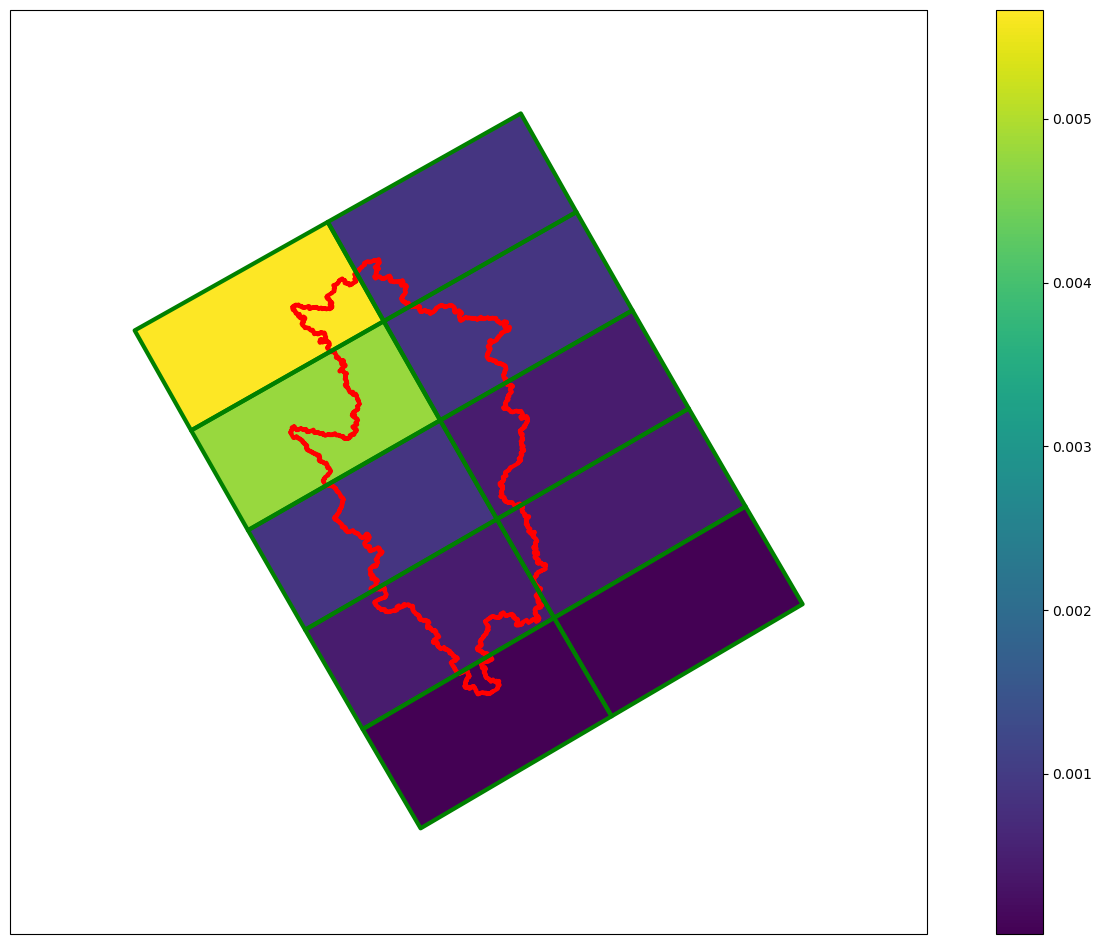

In [19]:
aea_crs = ccrs.AlbersEqualArea(central_longitude=100,
                               standard_parallels=(50, 70),
                               central_latitude=56,
                               false_easting=0,
                               false_northing=0)

merc_crs = ccrs.Mercator()

fig = plt.figure(figsize=(18, 12))
ax = plt.axes(projection=aea_crs)
# find extent coordinates
min_lon, max_lon, min_lat, max_lat = find_extent(ws=random_geom,
                                                 grid_res=0.125,
                                                 dataset='era5')
# W, E, S, N
ax.set_extent([min_lon-0.25, max_lon+0.25, min_lat-0.25, max_lat+0.25],
              crs=ccrs.PlateCarree())

fig = plt.pcolor(mask_nc['lon'], mask_nc['lat'],
                 mask_nc * 1e3, 
                 shading='auto',
                 transform=ccrs.PlateCarree())

plt.colorbar(fig)

ax.add_geometries([random_geom],
                  crs=ccrs.PlateCarree(),
                  facecolor="None",
                  edgecolor='red',
                  linewidth=3)

ax.add_geometries([poly for poly in poly_weights['geometry']],
                  crs=ccrs.PlateCarree(),
                  facecolor="None",
                  edgecolor='green',
                  linewidth=3)
ax.patch.set_alpha(0)

plt.show()

In [20]:
(mask_nc * 1e3).to_netcdf('../paper_visualisation/weight_mask/example_nc.nc')
ws_gdf.to_file('../paper_visualisation/weight_mask/actual_ws.gpkg')
poly_weights.to_file('../paper_visualisation/weight_mask/weights_mask.gpkg')